# Keras as PCA Alternative

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from scipy.stats import f_oneway

In [16]:
df = pd.read_excel("C:/Users/daanm/Documents/Universiteit Utrecht/Scriptie/dataset.xlsx")
df.head()

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,eng_language,expend,irrigated_land_bin,...,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip,ratio_insured_cattle
0,1,4,No,25,Yes,No,Never attended,No,0,1,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes,0.0
1,2,4,Yes,27,Yes,No,Adult Education,No,0,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
2,3,4,Yes,29,No,No,Elementary,No,1,0,...,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
3,4,4,No,35,Yes,No,Never attended,No,0,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
4,6,4,No,60,Yes,No,Never attended,No,0,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,No,0.0


In [17]:
list(df)

['id',
 'wave',
 'afm_language',
 'age_constant',
 'agric_land',
 'amh_language',
 'educ_recoded_constant',
 'eng_language',
 'expend',
 'irrigated_land_bin',
 'buy_cattle',
 'buy_nr_cattle',
 'n_previd_cattle',
 'cs_cs_diff_post_cattle',
 'cs_cs_ratio_post_cattle',
 'number_minors',
 'educ_child_recoded',
 'activity_child_recoded',
 'household_description',
 'number_adults',
 'main_info_source_recoded',
 'religion_recoded',
 'owns_phone',
 'household_moved',
 'purchase_bin',
 'why_not_purchase_recoded',
 'know_vip',
 'trust_vip',
 'advise_vip',
 'ratio_insured_cattle']

# Train the autoencoder KERAS

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

#remove the outcome variable
y = df['cs_cs_diff_post_cattle']
X = df.drop(columns=['cs_cs_diff_post_cattle'])

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

#Encode
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X)


#Train/test split
X_train, X_test = train_test_split(X_preprocessed, test_size=0.2, random_state=42)

#Train the autoencoder
input_dim = X_preprocessed.shape[1]
encoding_dim = 20  # Dimensions

# Layers
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded_output = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded_output)
decoded = Dense(64, activation='relu')(decoded)
decoded_output = Dense(input_dim, activation='linear')(decoded)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded_output)

# Encoder Model
encoder = Model(inputs=input_layer, outputs=encoded_output)

autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1)


# Encode the dataset
encoded_features = encoder.predict(X_preprocessed)
encoded_df = pd.DataFrame(encoded_features, columns=[f"latent_{i+1}" for i in range(encoding_dim)])

# Transform to dataset

encoded_df['cs_cs_diff_post_cattle'] = y.values


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3823 - val_loss: 0.2953
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1966 - val_loss: 0.2280
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1389 - val_loss: 0.2010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1135 - val_loss: 0.1777
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0882 - val_loss: 0.1632
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0732 - val_loss: 0.1544
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0666 - val_loss: 0.1492
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0626 - val_loss: 0.1469
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0606 - val_loss: 0.1451
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - val_loss: 0.1435
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569 - val_loss: 0.1401
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

# Visualize the results

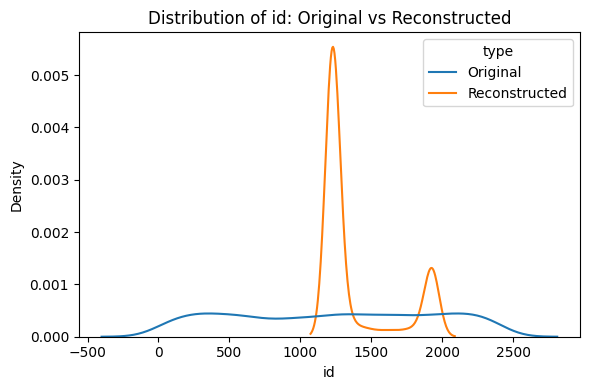

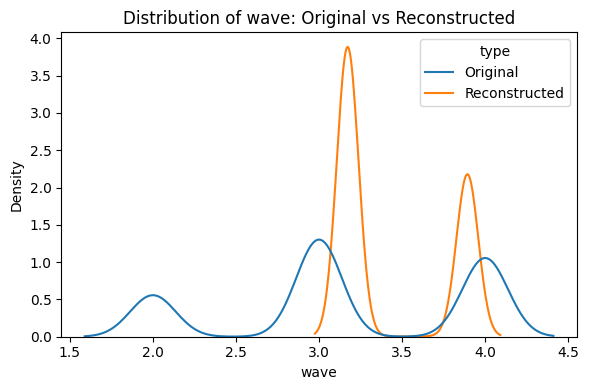

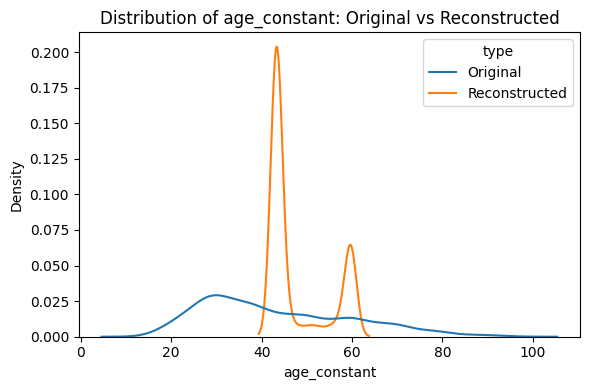

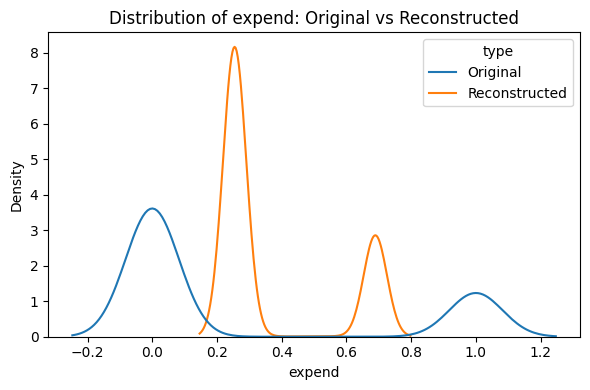

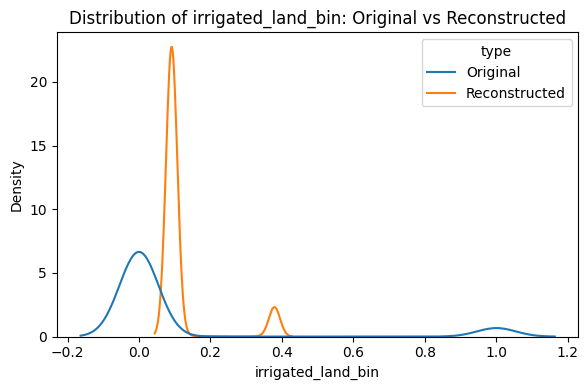

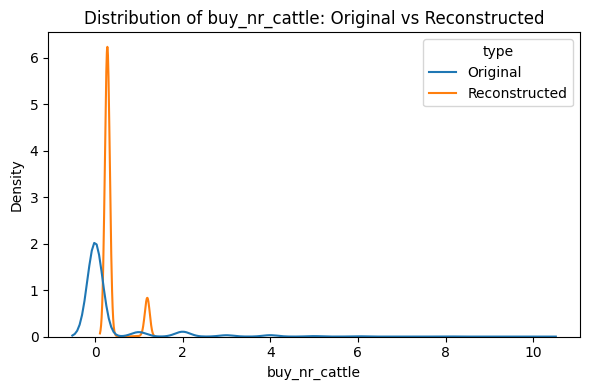

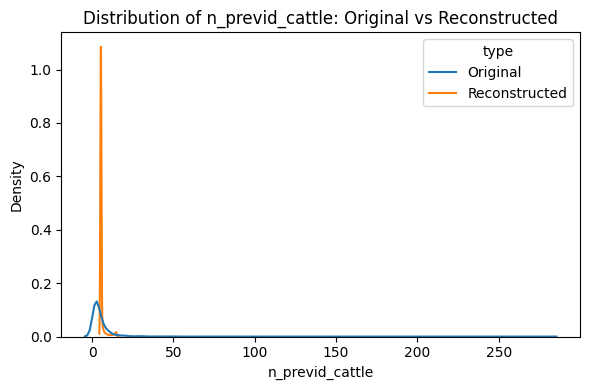

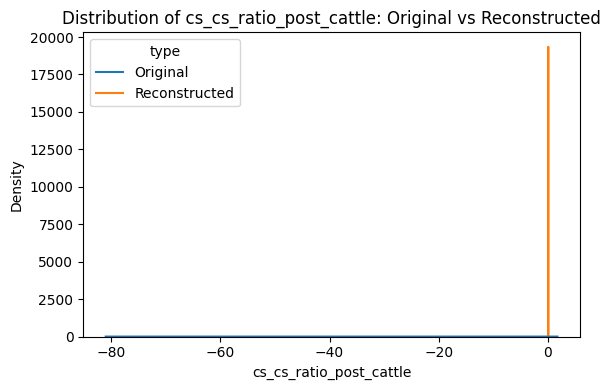

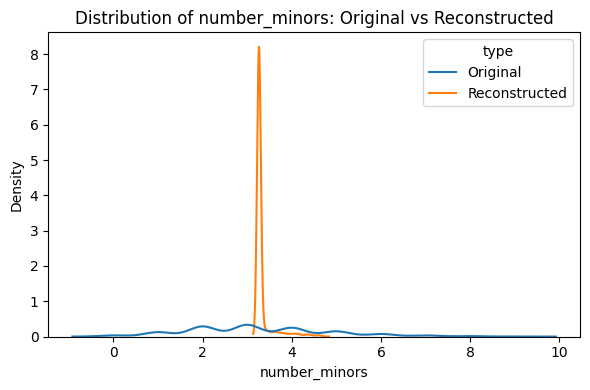

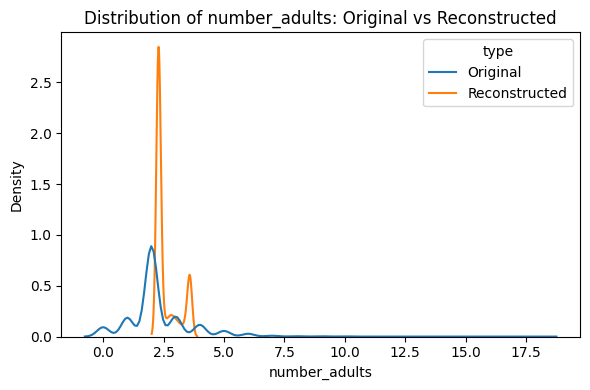

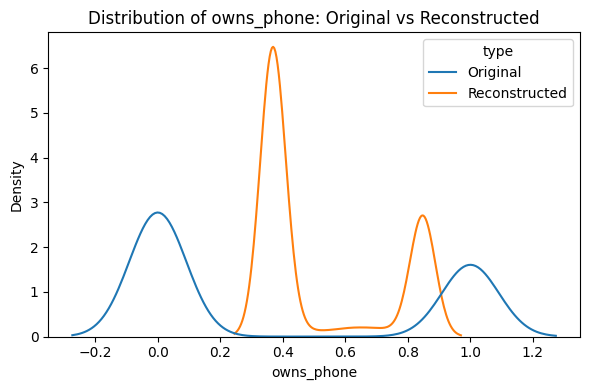

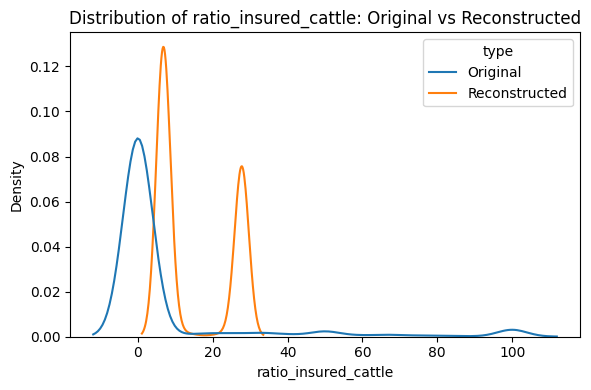

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = df.drop(columns=['cs_cs_diff_post_cattle'])

# Define numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Recreate preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)

# Split data into num/cat
X_reconstructed_num = X_reconstructed[:, :len(numerical_cols)]
X_reconstructed_cat = X_reconstructed[:, len(numerical_cols):]

X_processed_num = X_processed[:, :len(numerical_cols)]
X_processed_cat = X_processed[:, len(numerical_cols):]

# Inverse transform numerical data
X_reconstructed_num_df = pd.DataFrame(
    preprocessor.named_transformers_['num'].inverse_transform(X_reconstructed_num),
    columns=numerical_cols
)
X_original_num_df = pd.DataFrame(
    preprocessor.named_transformers_['num'].inverse_transform(X_processed_num),
    columns=numerical_cols
)

# Add labels for plotting
X_reconstructed_num_df['type'] = 'Reconstructed'
X_original_num_df['type'] = 'Original'

# Combine for plotting
comparison_df = pd.concat([X_original_num_df, X_reconstructed_num_df])

# Plot KDEs for each numerical feature
import matplotlib.pyplot as plt
import seaborn as sns

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=comparison_df, x=col, hue='type', common_norm=False)
    plt.title(f'Distribution of {col}: Original vs Reconstructed')
    plt.tight_layout()
    plt.show()


If the model would have performed well, it would have had similar peaks in the reconstructed dataset as the original dataset. As can be seen in the plots above, it does not have these peaks at the same places. This means this model is not suited for the reconstruction of the dataset.

In [26]:
encoded_df.head()

,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,...,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19,latent_20,cs_cs_diff_post_cattle
0,0.0,4.886102,5.527393,3.543075,5.584939,0.841902,2.494719,0.0,6.815660,2.267889,...,0.0,6.210609,2.758893,2.436445,0.0,6.408684,0.0,1.525664,9.240917,-188.170624
1,0.0,2.783890,3.635398,3.009839,3.136785,1.767617,2.038048,0.0,4.452082,2.168335,...,0.0,4.340715,3.567550,1.459997,0.0,3.513125,0.0,2.550178,8.504108,-850.367249
2,0.0,3.726837,3.733514,3.138005,3.254053,3.103416,1.431260,0.0,3.163959,2.378227,...,0.0,4.957175,4.908027,1.933444,0.0,3.149253,0.0,3.009468,7.352082,-5219.686523
3,0.0,2.840463,3.202998,2.836660,3.795675,2.375401,3.095271,0.0,3.715101,2.971171,...,0.0,4.714443,2.797792,2.046384,0.0,3.751456,0.0,3.052495,8.623713,-157.544266
4,0.0,2.396936,3.180709,3.354150,2.073421,1.460459,2.306925,0.0,4.077400,1.901585,...,0.0,4.845815,2.173893,2.978191,0.0,3.606626,0.0,1.302435,7.455321,-158.881271
